<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Evaluating SVR on Multiple Datasets


---

In this lab you can explore several datasets with SVM regressors compared to linear regression with and without regularisation. 

First, use the 

**Bike share data**

    resource-datasets/bikeshare
    
    regression to predict casual


Then, use any of the following datasets:

**Auto**

    resource-datasets/auto_stats

    regression to predict mpg

**Boston housing data**

    resource-datasets/boston_housing_data

    regression to predict MEDV

**Wine data**

    resource-datasets/wine_data
    
    regression to predict the quality

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn import datasets
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

## A: Wine data set

### 1. Load the dataset

- Are there any missing values? Impute or clean if so.
- Select a regression target and predictors.
- Rescale the data.

In [3]:
# Read in bikeshare data
X = pd.read_csv('../../../../../resource-datasets/wine_data/winequality_merged.csv')
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [4]:
X.dropna(inplace=True)
X.drop(X.columns[0],axis=1,inplace=True)
X = pd.get_dummies(X,columns=['red_wine'],drop_first=True)

In [5]:
y = X.pop('quality')

In [6]:
X.shape, y.shape

((6497, 11), (6497,))

In [7]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns)

### 2. Build an SVM regressor on the data

See the documentation for details about the [SVM-regressor](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR).

- Initialize and train a linear SVM with the default settings. What is the average R2-score with 5-fold cross validation?
- Repeat using a radial basis function (rbf) regressor. Compare the scores. Which one is better?

In [9]:
def get_score(model, X_train, y_train, X_test, y_test, cv=5):
    model.fit(X_train,y_train)
    scores_train = cross_val_score(model, X_train, y_train, cv=cv)
    predictions_test = model.predict(X_test) 
    sm = scores_train.mean()
    print(("Average traininig score: {:0.3}".format(sm)))
    print(("Test score: {:0.3}".format(model.score(X_test, y_test))))
    return predictions_test

In [10]:
#Keep in mind LinearSVR is faster than the general SVM with linear kernel
model_lin = LinearSVR() 
model_rbf = SVR(kernel='rbf')
model_poly = SVR(kernel='poly', degree=2)

In [11]:
predictions = get_score(model_lin, X_train, y_train, X_test, y_test, cv=5)
predictions = get_score(model_rbf, X_train, y_train, X_test, y_test, cv=5)
#predictions = get_score(model_poly, X_train, y_train, X_test, y_test, cv=5)

Average traininig score: 0.29
Test score: 0.272
Average traininig score: 0.385
Test score: 0.386


### 3. Tune the SVM regressors with gridsearch

- Check in the documentation which parameters can be tuned in combination with different kernels.
- Create a further train-test split to obtain a hold-out validation set.
- Cross-validate scores.

In [12]:
def grid_search_func(estimator, params, X_train, y_train, X_test, y_test, scoring_function=metrics.r2_score, scoring='r2', cv=5):
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        return_train_score=True,
        scoring=scoring,
        cv=cv)

    gs.fit(X_train, y_train)

    print("Best score")
    print(gs.best_score_)
    print()
    print("Best estimator")
    print(gs.best_estimator_.get_params())
    print()

    predictions = gs.best_estimator_.predict(X_test)
    print('Test score: ', scoring_function(y_test, predictions))


    return gs

In [13]:
params_lin = {
    'C': np.logspace(-3, 2, 3),
    'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
    'fit_intercept': [True,False]
}

gs_lin = grid_search_func(model_lin, params_lin,
                          X_train, y_train, X_test, y_test)

Best score
0.2926354353126955

Best estimator
{'C': 0.31622776601683794, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000, 'random_state': None, 'tol': 0.0001, 'verbose': 0}

Test score:  0.27078081699433143


In [14]:
params_rbf = {
    'C': np.logspace(-3, 2, 3),
    'gamma': np.logspace(-5, 2, 3),
    'kernel': ['rbf']
}

gs_rbf = grid_search_func(model_rbf,params_rbf,X_train,y_train,X_test,y_test)

Best score
0.3514063865115488

Best estimator
{'C': 0.31622776601683794, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.03162277660168379, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Test score:  0.34025315154301994


In [15]:
params_poly = {
    'C': np.logspace(-3, 2, 3),
    'gamma': np.logspace(-5, 2, 3),
    'degree': [2,3]
}
# that would take a long time
#gs_poly = grid_search_func(model_poly,params_poly,X_train,y_train,X_test,y_test)

### 4. Compare to linear regression with and without regularisation.

- Gridsearch optimal parameters 
- Cross-validate scores.
- Examine the R2.

In [16]:
# Evaluate MSE for whole model using LinearRegression (no regularisation), then regularised regression
lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()

In [17]:
predictions = get_score(lm, X_train, y_train, X_test, y_test, cv=5)
predictions = get_score(lasso, X_train, y_train, X_test, y_test, cv=5)
predictions = get_score(ridge, X_train, y_train, X_test, y_test, cv=5)

Average traininig score: 0.293
Test score: 0.271
Average traininig score: -0.00136
Test score: -0.00173
Average traininig score: 0.293
Test score: 0.271


In [18]:
params_ridge = {'alpha': np.logspace(-10, 10, 21),
          'fit_intercept': [True, False]}

gs_ridge = grid_search_func(ridge, params_ridge,
                          X_train, y_train, X_test, y_test)

Best score
0.2927173363286706

Best estimator
{'alpha': 10.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

Test score:  0.2708159451110769


In [19]:
params_lasso = {'alpha': np.logspace(-5, 10, 21),
          'fit_intercept': [True, False]}

gs_lasso = grid_search_func(lasso, params_lasso,
                          X_train, y_train, X_test, y_test)

Best score
0.2927006134235785

Best estimator
{'alpha': 0.00031622776601683794, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

Test score:  0.2707111546380859


In [20]:
gs_results = pd.DataFrame(gs_ridge.cv_results_)
gs_lasso_results = pd.DataFrame(gs_lasso.cv_results_)

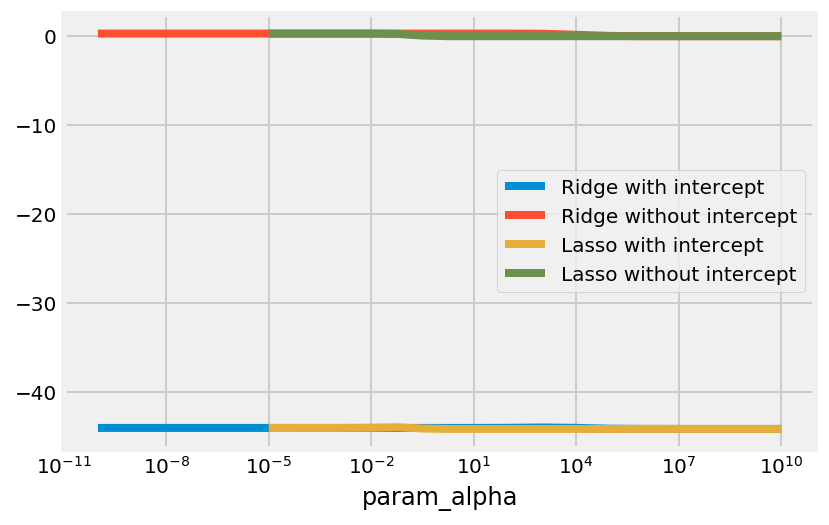

In [21]:
fig, ax = plt.subplots()
gs_results.groupby('param_fit_intercept').plot(
    x='param_alpha',
    y='mean_test_score',
    logx=True,
    ax=ax)

gs_lasso_results.groupby('param_fit_intercept').plot(
    x='param_alpha',
    y='mean_test_score',
    logx=True,
    ax=ax)
ax.legend(['Ridge with intercept','Ridge without intercept',
           'Lasso with intercept','Lasso without intercept'])
plt.show()